# Collect results from multiple runs of `jaxmodel.ipynb` 

In [17]:
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy

In [18]:
# papermill params
results_dir = 'papermill_results/'

In [19]:
# recurse through the subdirectories, parsing the directory name, and adding it to the dataframe
keys = []
mut_df_collection = pd.DataFrame()
for dir in glob.glob(f'{results_dir}*/'):
    mut_df = pd.read_csv(f"{dir}/mutations_df.csv")
    for annotation in dir.split("/")[-2].split("--"):
        key, val = annotation.split("=")
        keys.append(key)
        mut_df[key] = val
    mut_df_collection = pd.concat([mut_df_collection, mut_df])
mut_df_collection

,mutation,wts,sites,muts,times_seen_Delta,times_seen_Omicron_BA1,times_seen_Omicron_BA2,beta_Delta,shift_Delta,beta_Omicron_BA1,shift_Omicron_BA1,beta_Omicron_BA2,shift_Omicron_BA2,fusionreg,global_epistasis,l2reg,loss_fn,replicate
0,M1F,M,1,F,3,0,0,-0.339940,-0.339940,0.000000,0.0,0.000000,0.000000,0,Identity,0.001,count_loss,2
1,M1I,M,1,I,9,4,5,-1.769593,0.520765,-2.290358,0.0,-3.010576,-0.720218,0,Identity,0.001,count_loss,2
2,M1K,M,1,K,4,0,0,-1.158312,-1.158312,0.000000,0.0,0.000000,0.000000,0,Identity,0.001,count_loss,2
3,M1L,M,1,L,6,0,1,-1.608822,-1.608822,0.000000,0.0,-2.598597,-2.598597,0,Identity,0.001,count_loss,2
4,M1R,M,1,R,0,0,1,0.000000,0.000000,0.000000,0.0,-2.031622,-2.031622,0,Identity,0.001,count_loss,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10278,S1252V,S,1252,V,13,55,60,0.091112,-0.259195,0.350307,0.0,0.037935,-0.312372,1.0,Identity,0.001,count_loss,2
10279,S1252W,S,1252,W,8,24,28,0.397481,0.012046,0.385435,0.0,0.329574,-0.055861,1.0,Identity,0.001,count_loss,2
10280,S1252Y,S,1252,Y,32,84,143,0.205094,-0.573238,0.778332,0.0,0.412604,-0.365728,1.0,Identity,0.001,count_loss,2
10281,S1252*,S,1252,*,0,1,1,-0.214861,0.000000,-0.214861,0.0,-0.214861,0.000000,1.0,Identity,0.001,count_loss,2


In [20]:
mut_df_collection.query("muts == '-'").shape[0]

3012

In [21]:
mut_df_collection['fusionreg'] = mut_df_collection['fusionreg'].astype(float)
mut_df_collection['l2reg'] = mut_df_collection['l2reg'].astype(float)

In [22]:
# make the mutation collection of parameter values tall for easier plotting
id_vars = ["mutation", "wts", "sites", "muts"] + list(set(keys)) #+ [c for c in mut_df_collection.columns if "times_seen" in c]
parameters = [c for c in mut_df_collection.columns if ("beta" in c) or ("shift" in c)]
tall_mut_df_collection = (
    mut_df_collection
    .melt(
        id_vars=id_vars,
        value_vars=parameters,
        var_name="parameter",
        value_name="value",
    )
    .pivot_table(
        index=list(set(id_vars + ["parameter"])-set(["replicate"])),
        columns="replicate",
        values="value"
    )
    .reset_index()
    .sort_values(by=["fusionreg", "l2reg"], ascending=False)
    # make scientific notation string columns for fusionreg and l2reg
    .assign(
        fusionreg_sci=lambda x: x["fusionreg"].apply(lambda y: f"{y:.1e}"),
        l2reg_sci=lambda x: x["l2reg"].apply(lambda y: f"{y:.1e}"),
        is_stop=lambda x: x["mutation"].apply(lambda y: "*" in y)
    )
)
tall_mut_df_collection.index.name="index"
tall_mut_df_collection.head()

replicate,muts,mutation,fusionreg,wts,l2reg,loss_fn,global_epistasis,sites,parameter,1,2,fusionreg_sci,l2reg_sci,is_stop
index,,,,,,,,,,,,,,
18,*,A1020*,3.0,A,0.001,count_loss,Identity,1020,beta_Delta,0.0,-2.868767,3.0e+00,1.0e-03,True
19,*,A1020*,3.0,A,0.001,count_loss,Identity,1020,beta_Omicron_BA1,0.0,-2.868767,3.0e+00,1.0e-03,True
20,*,A1020*,3.0,A,0.001,count_loss,Identity,1020,beta_Omicron_BA2,0.0,-2.868767,3.0e+00,1.0e-03,True
21,*,A1020*,3.0,A,0.001,count_loss,Identity,1020,shift_Delta,0.0,0.000000,3.0e+00,1.0e-03,True
22,*,A1020*,3.0,A,0.001,count_loss,Identity,1020,shift_Omicron_BA1,0.0,0.000000,3.0e+00,1.0e-03,True


In [23]:
tall_mut_df_collection.columns

Index(['muts', 'mutation', 'fusionreg', 'wts', 'l2reg', 'loss_fn',
       'global_epistasis', 'sites', 'parameter', '1', '2', 'fusionreg_sci',
       'l2reg_sci', 'is_stop'],
      dtype='object', name='replicate')

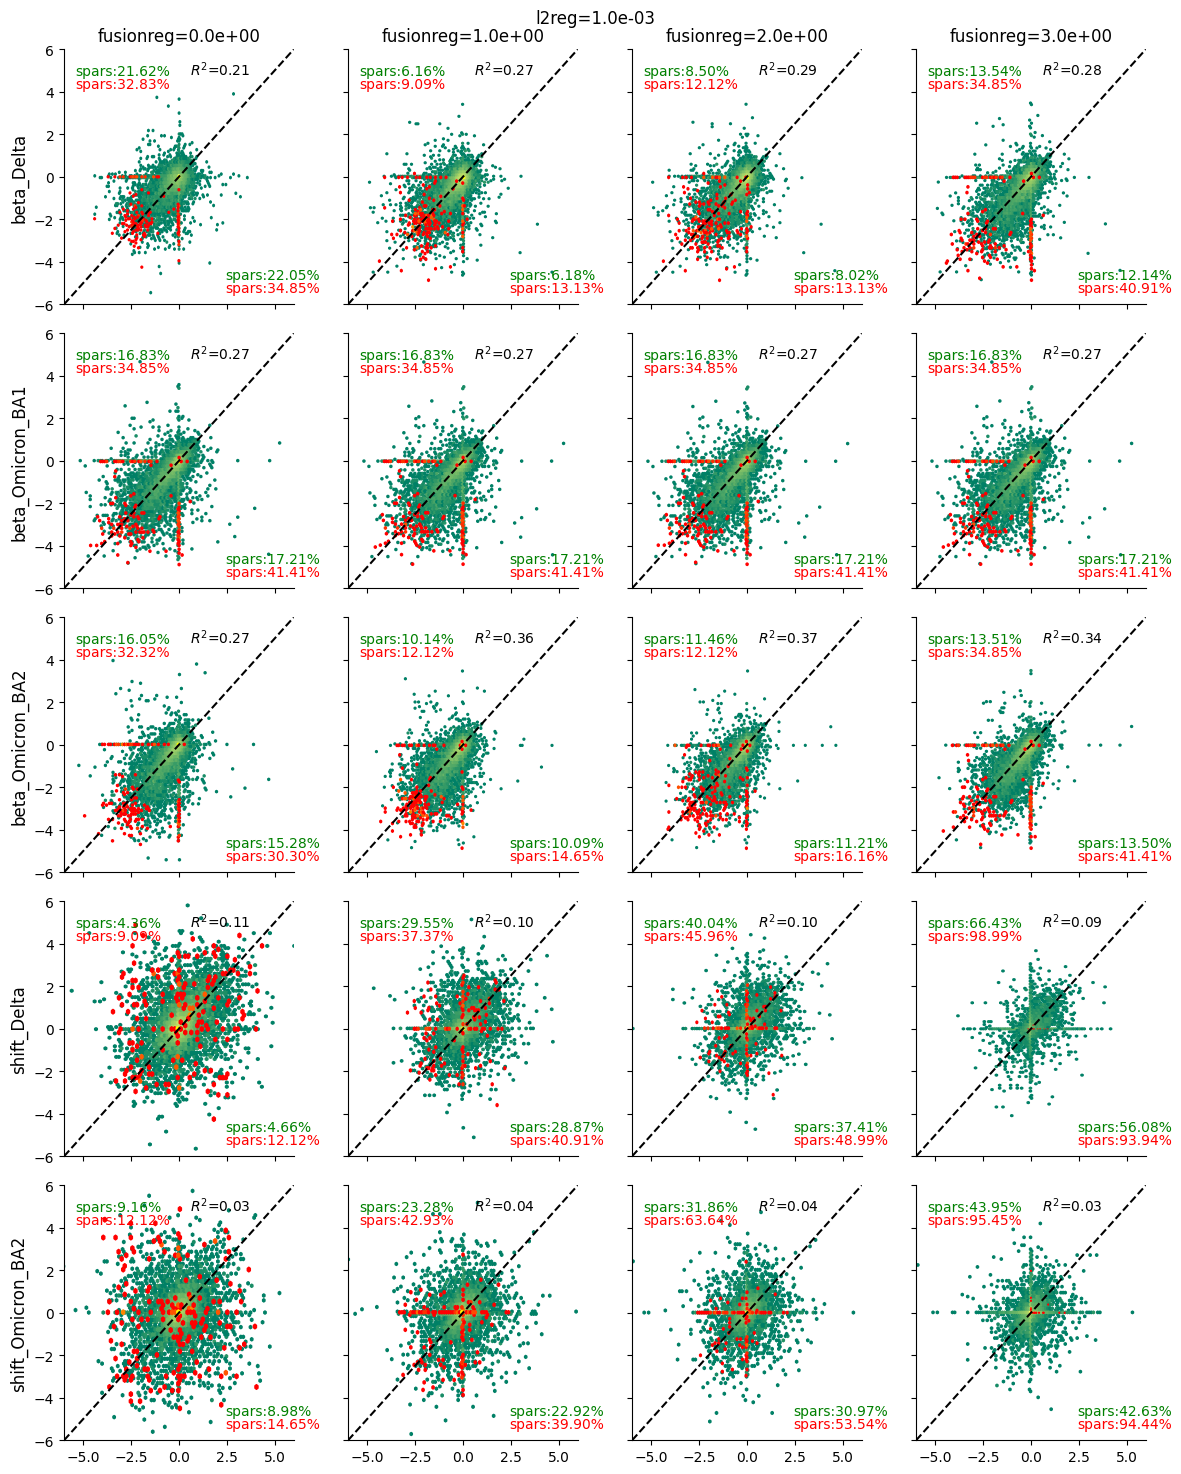

In [24]:
# use facets to create a scatter with column '1' on the x and column '2' on the y, facetted by parameter, fusionreg, and l2reg
for l2reg, df in tall_mut_df_collection.query(f"parameter != 'shift_Omicron_BA1'").dropna().groupby("l2reg_sci"):

    # loop through each
    num_rows = len(df["parameter"].unique())
    num_cols = len(df["fusionreg_sci"].unique())
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(num_cols*3, num_rows*3), sharex=True, sharey=True, squeeze=False)

    for row, (parameter, sub_df) in enumerate(df.groupby("parameter")):
        for col, (fusionreg, sub_sub_df) in enumerate(sub_df.groupby("fusionreg_sci")):
        
            iter_ax = ax[row, col]
            iter_ax.plot([0, 1], [0, 1], transform=iter_ax.transAxes, color="black", linestyle="--")

            iter_ax.hexbin(
                sub_sub_df.query("~is_stop")["1"], sub_sub_df.query("~is_stop")["2"],
                bins="log",
                gridsize=100,
                cmap="summer",
            )
            iter_ax.hexbin(
                sub_sub_df.query("is_stop")["1"], sub_sub_df.query("is_stop")["2"],
                bins="log",
                gridsize=50,
                cmap="autumn",
            )
            # compute R squared and annotate figure
            r_squared = scipy.stats.pearsonr(sub_sub_df["1"], sub_sub_df["2"]).statistic ** 2
            iter_ax.annotate(f"$R^2$={r_squared:.2f}", xy=(0.55, 0.90), xycoords='axes fraction')

            # compute percentage of muts that are equal to zero for both stop, and non-stop mutations
            non_stop_zero = (sub_sub_df.query("~is_stop")["1"] == 0).mean()
            iter_ax.annotate(f"spars:{non_stop_zero:.2%}", xy=(.7, .10), xycoords='axes fraction', color="green")

            stop_zero = (sub_sub_df.query("is_stop")["1"] == 0).mean()
            iter_ax.annotate(f"spars:{stop_zero:.2%}", xy=(.7, .05), xycoords='axes fraction', color="red")

            non_stop_zero = (sub_sub_df.query("~is_stop")["2"] == 0).mean()
            iter_ax.annotate(f"spars:{non_stop_zero:.2%}", xy=(.05, .9), xycoords='axes fraction', color="green")

            stop_zero = (sub_sub_df.query("is_stop")["2"] == 0).mean()
            iter_ax.annotate(f"spars:{stop_zero:.2%}", xy=(.05, .85), xycoords='axes fraction', color="red")

            iter_ax.set_xlabel(None)
            iter_ax.set_ylabel(None)
            iter_ax.set_xlim(-6, 6)
            iter_ax.set_ylim(-6, 6)

            if row == 0:
                iter_ax.set_title(f"fusionreg={fusionreg}")
            if col == 0:
                iter_ax.set_ylabel(parameter, size=12)
    
    fig.suptitle(f"l2reg={l2reg}")
    sns.despine()
    plt.tight_layout()
    plt.show()
    # break
            